In [1]:
import torch
import csv
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn import metrics


DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
ADJACENCY_MATRICES_PATH = f'{DATA_PATH}/distance-matrices' 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
DISTANCE_THRESHOLD = 10
CLASS_THRESHOLD = 0.75 # threshold set according to the MCC for different threshold, tried below
def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id],embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys


def get_adjacency_info(id):
    distance_matrix = np.load(f'{ADJACENCY_MATRICES_PATH}/{id}.npy')

    edge_indices = []

    for iy, ix in np.ndindex(distance_matrix.shape):
        if iy >= ix:
            continue

        if distance_matrix[iy, ix] <= DISTANCE_THRESHOLD:
            edge_indices += [[iy, ix], [ix, iy]]
    
    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices


def load_dataset(dataset_annotation_filepath):
    Xs, Ys = process_sequence_dataset(dataset_annotation_filepath, [ESM_EMBEDDINGS_PATH])

    protein_list = []
    for key in Xs.keys():
        protein_features = torch.tensor(Xs[key], dtype=torch.float32)
        protein_labels = torch.tensor(Ys[key], dtype=torch.int64)
        protein_edges = get_adjacency_info(key)
        protein = Data(x=protein_features, edge_index=protein_edges, y=protein_labels)
        protein_list.append(protein)
        if protein_edges.shape[1] > 0:
            if protein_edges.max() >= protein_features.size(0):
                print(f'{key}: {protein_edges.max()}, {protein_features.size(0)}')
        
    return protein_list


In [3]:
test_proteins = load_dataset(f'{DATA_PATH}/test.txt')
train_proteins = load_dataset(f'{DATA_PATH}/train.txt')

In [4]:

DROPOUT = 0.3
EMBEDDING_DIM = 2560
HEADS = 16
HIDDEN_CHANNELS = 100
LAYER_WIDTH = 256

class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.dropout0 = nn.Dropout(DROPOUT)

        self.conv1 = GATConv(EMBEDDING_DIM, HIDDEN_CHANNELS, heads=HEADS, dropout=DROPOUT, concat=False)
        # self.dropout00 = nn.Dropout(DROPOUT)

        # self.conv2 = GATConv(HIDDEN_CHANNELS, HIDDEN_CHANNELS, heads=HEADS,
        #                     concat=False, dropout=DROPOUT)

        self.linear1 = nn.Linear(HIDDEN_CHANNELS, LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)
        
        self.linear2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.linear3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)
        self.dropout3 = nn.Dropout(DROPOUT)

        self.relu = nn.LeakyReLU()

    def forward(self, x, edge_index):
        x = self.dropout0(x)
    
        x = self.conv1(x, edge_index)
        # x = self.relu(x)
        # x = self.dropout00(x)

        # x = self.conv2(x, edge_index)

        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear1(x)

        x = x.relu()
        x = self.dropout2(x)
        x = self.linear2(x)

        x = x.relu()
        x = self.dropout3(x)
        x = self.linear3(x)

        return x

In [5]:
# computed externally:
class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train(model, optimizer, epochs, train_dataloader, test_dataloader):
    model = model.to(device)


    # compute class weights (because the dataset is heavily imbalanced)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():
            for batch_id, data in enumerate(test_dataloader):   
                X_test = data.x.to(device)
                y_test = data.y.to(device).float()
                edges = data.edge_index.to(device)

                test_logits = model(X_test, edges).squeeze()
                test_probs = torch.sigmoid(test_logits)
                test_pred = test_probs > CLASS_THRESHOLD

                test_loss = loss_fn(test_logits,
                                    y_test)
                test_losses.append(test_loss.cpu().detach().numpy())

                # compute metrics on test dataset                
                test_acc = accuracy_fn(y_true=y_test,
                                       y_pred=test_pred)
                fpr, tpr, thresholds1 = metrics.roc_curve(y_test.cpu().float().numpy(), torch.sigmoid(test_logits).cpu().float().numpy())
                roc_auc = metrics.auc(fpr, tpr)

                mcc = metrics.matthews_corrcoef(y_test.cpu().float().numpy(), test_pred.cpu().float().numpy())

                f1 = metrics.f1_score(y_test.cpu().float().numpy(), test_pred.cpu().float().numpy(), average='weighted')

                precision, recall, thresholds2 = metrics.precision_recall_curve(y_test.cpu().float().numpy(), torch.sigmoid(test_logits).cpu().float().numpy())
                auprc = metrics.auc(recall, precision)

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, data in enumerate(train_dataloader):
            x_batch = data.x.to(device)
            y_batch = data.y.to(device).float()
            edges = data.edge_index.to(device)
            model.train()
            optimizer.zero_grad()
            y_logits = model(x_batch, edges).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred.to(dtype=torch.int))}")
    np.savez(f'/home/skrhakv/cryptic-nn/src/models/auc-auprc/data/GAT-rocauc.npz', fpr, tpr, thresholds1)
    np.savez(f'/home/skrhakv/cryptic-nn/src/models/auc-auprc/data/GAT-auprc.npz', precision, recall, thresholds2)

    return train_losses, test_losses



In [9]:
BATCH_SIZE = 8

train_loader = DataLoader(train_proteins, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_proteins, batch_size=len(test_proteins))

model = GAT().to(device)
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

train_losses, test_losses = train(model, optimizer, 9, train_loader, test_loader)

# GAT
# Epoch: 37 | Loss: 0.58937, Accuracy: 73.02% | Test loss: 0.68671, AUC: 0.8636530251080131, MCC: 0.28348991842760934, sum: 17158.0

# GAT with two GraphConv layers:
# Epoch: 38 | Loss: 0.57613, Accuracy: 78.00% | Test loss: 0.65644, AUC: 0.8613790084269165, MCC: 0.30587807055399585, sum: 14093.0

# GAT with 64 heads:
# Epoch: 13 | Loss: 0.63359, Accuracy: 80.85% | Test loss: 0.63947, AUC: 0.8634635987324862, MCC: 0.32354901388028406, sum: 12346.0

# GAT without graph convolution layer:
# Epoch: 3 | Loss: 0.67172, Accuracy: 88.80% | Test loss: 0.59212, AUC: 0.877542770203408, MCC: 0.39554805894509715, sum: 7352.0
# Epoch: 60 | Loss: 0.54814, Accuracy: 88.31% | Test loss: 0.59526, AUC: 0.8762555172557703, MCC: 0.3913615526061533, sum: 7686.0

# GAT, distance=3:
# Epoch: 8 | Loss: 0.60385, Accuracy: 79.08% | Test loss: 0.62847, AUC: 0.8777589692266613, MCC: 0.3230871812092425, sum: 13581.0



# GAT, distance=8:
# Epoch: 10 | Loss: 0.74945, Accuracy: 83.07% | Test loss: 0.60357, AUC: 0.8786199743151742, MCC: 0.35114833713417515, sum: 11134.0

# GAT, distance=10:
# Epoch: 5 | Loss: 0.28078, Accuracy: 84.96% | Test loss: 0.60840, AUC: 0.8733979275390964, MCC: 0.3580552333081609, sum: 9835.0



# one GAT
# Epoch: 5 | Loss: 0.29615, Accuracy: 84.06% | Test loss: 0.61799, AUC: 0.8695, MCC: 0.3516, F1: 0.8773, AUPRC: 0.3570, sum: 10412
# two GATs
# Epoch: 5 | Loss: 0.51451, Accuracy: 91.55% | Test loss: 0.63681, AUC: 0.8591, MCC: 0.3530, F1: 0.9225, AUPRC: 0.3238, sum: 4541
# three GATs
# Epoch: 7 | Loss: 0.34148, Accuracy: 89.60% | Test loss: 0.66359, AUC: 0.8514, MCC: 0.3335, F1: 0.9105, AUPRC: 0.2890, sum: 5952


# distance=6
# Epoch: 5 | Loss: 0.29190, Accuracy: 92.23% | Test loss: 0.63418, AUC: 0.8626, MCC: 0.3627, F1: 0.9268, AUPRC: 0.3398, sum: 4040
# distance=8
# Epoch: 5 | Loss: 0.29615, Accuracy: 84.06% | Test loss: 0.61799, AUC: 0.8695, MCC: 0.3516, F1: 0.8773, AUPRC: 0.3570, sum: 10412
# distance=10
# Epoch: 5 | Loss: 0.29326, Accuracy: 92.85% | Test loss: 0.60966, AUC: 0.8736, MCC: 0.3884, F1: 0.9314, AUPRC: 0.3731, sum: 3743


# number of neurons = 256 (same as the baseline)
# Epoch: 8 | Loss: 0.66487, Accuracy: 93.20% | Test loss: 0.62006, AUC: 0.8662, MCC: 0.3640, F1: 0.9319, AUPRC: 0.3580, sum: 3137


Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 1.30793, Accuracy: 94.32% | Test loss: 1.01670, AUC: 0.4586, MCC: 0.0000, F1: 0.9156, AUPRC: 0.0542, sum: 0
Epoch: 1 | Loss: 0.97750, Accuracy: 94.32% | Test loss: 0.80869, AUC: 0.8025, MCC: 0.0000, F1: 0.9156, AUPRC: 0.1971, sum: 0
Epoch: 2 | Loss: 0.72584, Accuracy: 94.27% | Test loss: 0.67551, AUC: 0.8418, MCC: 0.1259, F1: 0.9197, AUPRC: 0.2577, sum: 297
Epoch: 3 | Loss: 0.57169, Accuracy: 92.27% | Test loss: 0.63372, AUC: 0.8593, MCC: 0.3388, F1: 0.9258, AUPRC: 0.3062, sum: 3752
Epoch: 4 | Loss: 0.42447, Accuracy: 92.73% | Test loss: 0.61903, AUC: 0.8658, MCC: 0.3604, F1: 0.9293, AUPRC: 0.3321, sum: 3557
Epoch: 5 | Loss: 0.59552, Accuracy: 92.82% | Test loss: 0.61294, AUC: 0.8694, MCC: 0.3726, F1: 0.9304, AUPRC: 0.3497, sum: 3598
Epoch: 6 | Loss: 0.61403, Accuracy: 92.65% | Test loss: 0.60633, AUC: 0.8716, MCC: 0.3859, F1: 0.9302, AUPRC: 0.3622, sum: 3910
Epoch: 7 | Loss: 0.28696, Accuracy: 92.63% | Test los

In [11]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/GAT.pt'
torch.save(model, OUTPUT_PATH)
# Epoch: 8 | Loss: 0.60913, Accuracy: 93.25% | Test loss: 0.60703, AUC: 0.8724, MCC: 0.3897, F1: 0.9335, AUPRC: 0.3738, sum: 3365


In [19]:
import os
import numpy as np
from sklearn import metrics

thresholds = np.arange(0.0, 1.0, 0.05)
for threshold in thresholds:
    with torch.inference_mode():
        for batch_id, data in enumerate(test_loader):   
            X_test = data.x.to(device)
            y_test = data.y.to(device).float()
            edges = data.edge_index.to(device)

            test_logits = model(X_test, edges).squeeze()
            test_probs = torch.sigmoid(test_logits)
            rounded_predictions = (test_probs > threshold).cpu().numpy().astype(int)
            y_test = data.y.to(device).float().cpu().numpy()

            acc = metrics.accuracy_score(y_test, rounded_predictions)

            mcc = metrics.matthews_corrcoef(y_test, rounded_predictions)
            f1 = metrics.f1_score(y_test, rounded_predictions, average='weighted')

            print(f"Threshold: {threshold:.2f} | Accuracy: {acc:.4f} | MCC: {mcc:.4f} | F1: {f1:.4f}")

Threshold: 0.00 | Accuracy: 0.0568 | MCC: 0.0000 | F1: 0.0061
Threshold: 0.05 | Accuracy: 0.5859 | MCC: 0.2105 | F1: 0.6913
Threshold: 0.10 | Accuracy: 0.6696 | MCC: 0.2402 | F1: 0.7579
Threshold: 0.15 | Accuracy: 0.7239 | MCC: 0.2615 | F1: 0.7978
Threshold: 0.20 | Accuracy: 0.7627 | MCC: 0.2818 | F1: 0.8249
Threshold: 0.25 | Accuracy: 0.7952 | MCC: 0.2955 | F1: 0.8468
Threshold: 0.30 | Accuracy: 0.8182 | MCC: 0.3088 | F1: 0.8620
Threshold: 0.35 | Accuracy: 0.8382 | MCC: 0.3222 | F1: 0.8751
Threshold: 0.40 | Accuracy: 0.8599 | MCC: 0.3358 | F1: 0.8889
Threshold: 0.45 | Accuracy: 0.8718 | MCC: 0.3399 | F1: 0.8963
Threshold: 0.50 | Accuracy: 0.8868 | MCC: 0.3500 | F1: 0.9057
Threshold: 0.55 | Accuracy: 0.8971 | MCC: 0.3499 | F1: 0.9118
Threshold: 0.60 | Accuracy: 0.9058 | MCC: 0.3603 | F1: 0.9173
Threshold: 0.65 | Accuracy: 0.9142 | MCC: 0.3569 | F1: 0.9220
Threshold: 0.70 | Accuracy: 0.9215 | MCC: 0.3551 | F1: 0.9259
Threshold: 0.75 | Accuracy: 0.9291 | MCC: 0.3608 | F1: 0.9303
Threshol

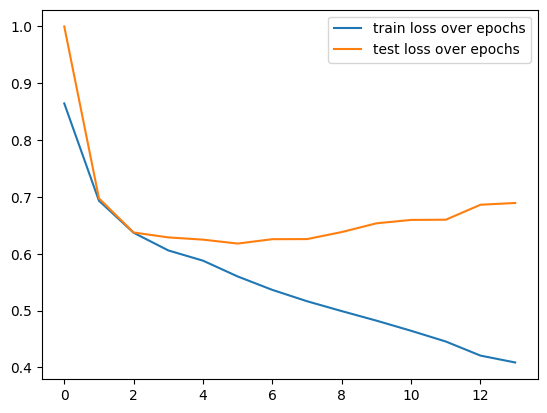

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()
plt.show()